In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load dataset
df = pd.read_csv("fake_news_dataset.csv")

In [3]:
# Standardize to lowercase strings if needed
df['label'] = df['label'].map({'Real': 0, 'Fake': 1})
df['label'] = df['label'].astype(int)


In [4]:
# Preview data
print(df.head())
print(df.info())

   id            title        author  \
0   1  Breaking News 1    Jane Smith   
1   2  Breaking News 2   Emily Davis   
2   3  Breaking News 3      John Doe   
3   4  Breaking News 4  Alex Johnson   
4   5  Breaking News 5   Emily Davis   

                                                text           state  \
0  This is the content of article 1. It contains ...       Tennessee   
1  This is the content of article 2. It contains ...       Wisconsin   
2  This is the content of article 3. It contains ...        Missouri   
3  This is the content of article 4. It contains ...  North Carolina   
4  This is the content of article 5. It contains ...      California   

  date_published          source       category  sentiment_score  word_count  \
0     30-11-2021       The Onion  Entertainment            -0.22        1302   
1     02-09-2021    The Guardian     Technology             0.92         322   
2     13-04-2021  New York Times         Sports             0.25         228   
3     

In [5]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())



Missing Values:
 id                   0
title                0
author               0
text                 0
state                0
date_published       0
source               0
category             0
sentiment_score      0
word_count           0
char_count           0
has_images           0
has_videos           0
readability_score    0
num_shares           0
num_comments         0
political_bias       0
fact_check_rating    0
is_satirical         0
trust_score          0
source_reputation    0
clickbait_score      0
plagiarism_score     0
label                0
dtype: int64


In [6]:
# Basic stats for numeric features
print("\nDescriptive Statistics:\n", df.describe())


Descriptive Statistics:
                 id  sentiment_score   word_count  char_count  has_images  \
count  4000.000000      4000.000000  4000.000000   4000.0000  4000.00000   
mean   2000.500000        -0.000645   795.655750   4277.0680     0.49650   
std    1154.844867         0.574768   406.373871   2186.2073     0.50005   
min       1.000000        -1.000000   100.000000    500.0000     0.00000   
25%    1000.750000        -0.490000   445.750000   2358.7500     0.00000   
50%    2000.500000        -0.010000   793.000000   4287.0000     0.00000   
75%    3000.250000         0.510000  1150.000000   6206.5000     1.00000   
max    4000.000000         1.000000  1500.000000   7996.0000     1.00000   

        has_videos  readability_score    num_shares  num_comments  \
count  4000.000000        4000.000000   4000.000000   4000.000000   
mean      0.484500          54.764595  25144.596750    489.870250   
std       0.499822          14.404027  14387.537467    287.435733   
min       0.0

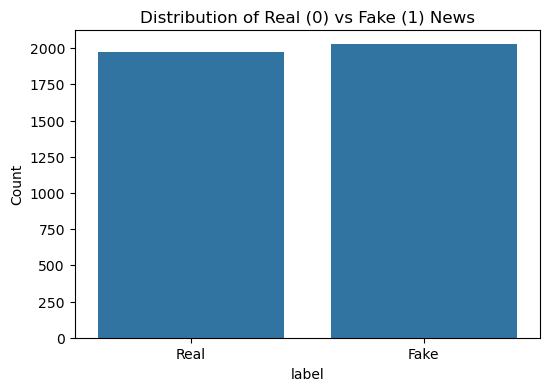

In [7]:
# Count of real vs. fake news
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Distribution of Real (0) vs Fake (1) News")
# plt.xlabel("label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()

In [8]:
df.columns.tolist()

['id',
 'title',
 'author',
 'text',
 'state',
 'date_published',
 'source',
 'category',
 'sentiment_score',
 'word_count',
 'char_count',
 'has_images',
 'has_videos',
 'readability_score',
 'num_shares',
 'num_comments',
 'political_bias',
 'fact_check_rating',
 'is_satirical',
 'trust_score',
 'source_reputation',
 'clickbait_score',
 'plagiarism_score',
 'label']

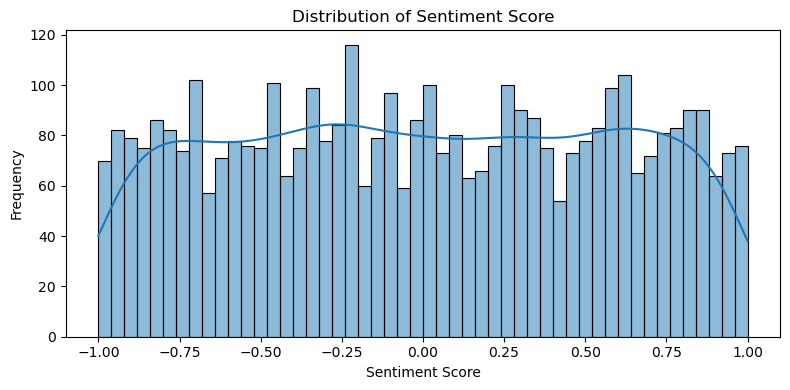

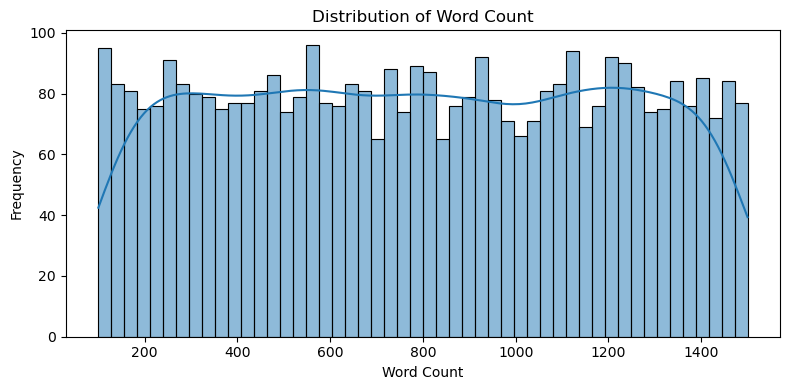

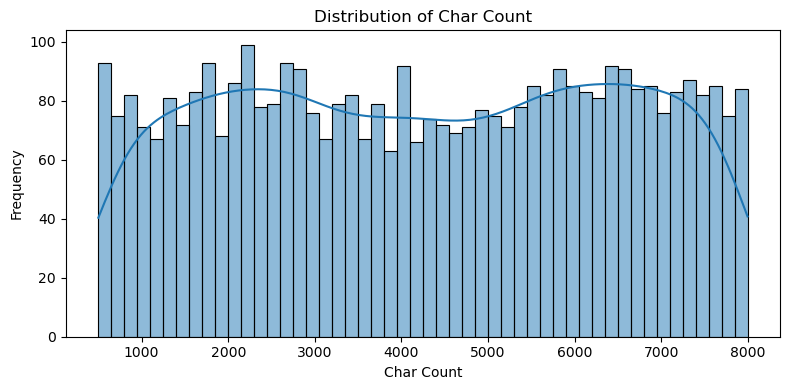

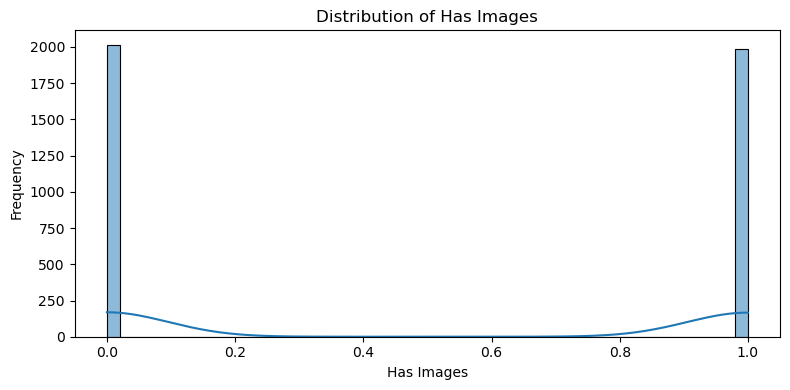

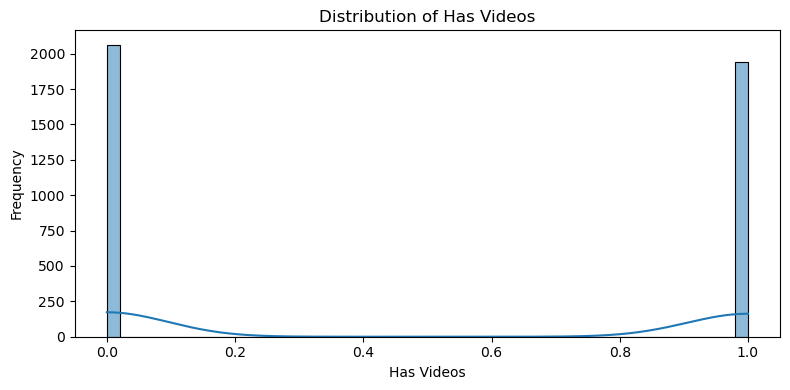

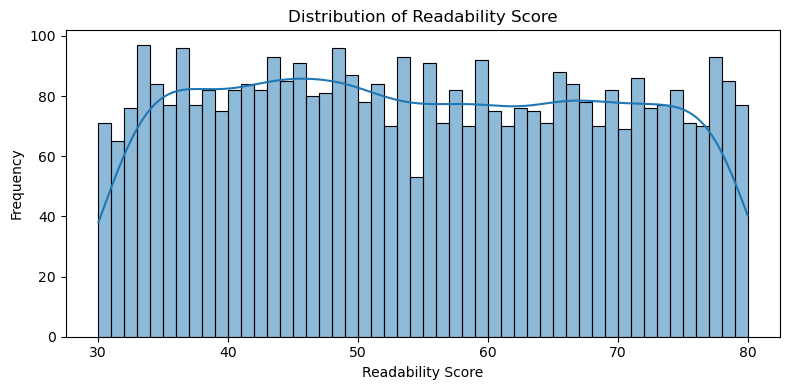

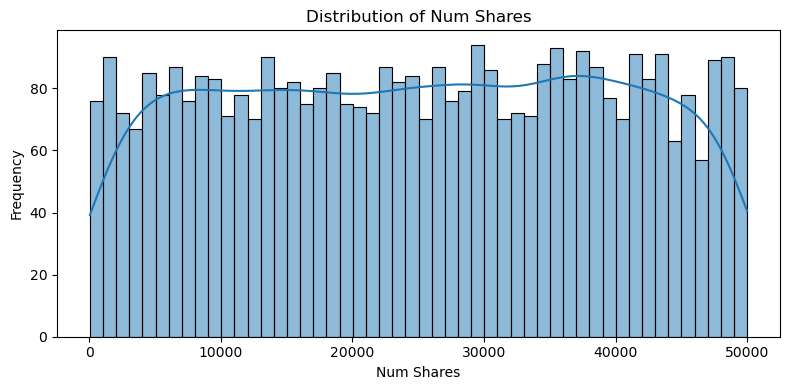

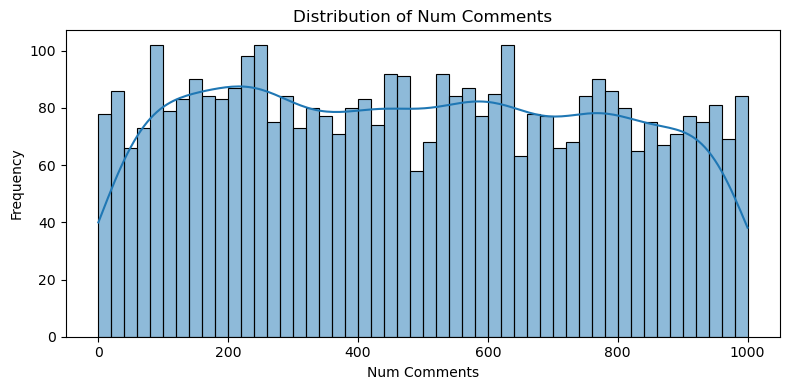

In [9]:
# List of numeric features to plot
features = [
    'sentiment_score',
    'word_count',
    'char_count',
    'has_images',
    'has_videos',
    'readability_score',
    'num_shares',
    'num_comments'
]

# Loop through each feature and create a histogram with KDE
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature.replace('_', ' ').title()}")
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


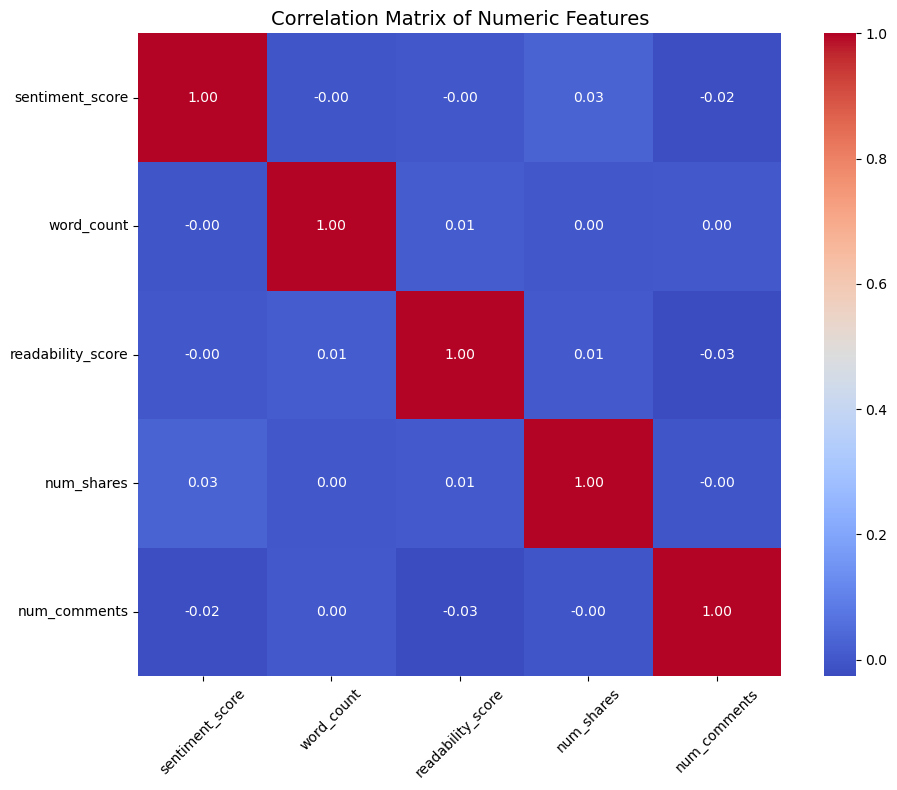

In [10]:
# Select only numeric columns for correlation
correlation_features = [
    'sentiment_score',
    'word_count',
    #'char_count',
    #'has_images',
    #'has_videos',
    'readability_score',
    'num_shares',
    'num_comments',
    #'is_satirical',
    #'trust_score',
    #'source_reputation',
    #'clickbait_score',
    #'plagiarism_score'
]

# Compute correlation matrix
corr_matrix = df[correlation_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Numeric Features", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


based on this correlation matrix the variables that stick best with each other are:<br>
<br>
sentiment_score and num_shares <br>
num_comments and readiblilty <br>
num_comments and sentiment_score

In [12]:
# Make a copy to avoid modifying the original DataFrame
df_encoded = df.copy()

# --- One-hot encode 'has_images' and 'has_videos'
df_encoded = pd.get_dummies(df_encoded, columns=['has_images', 'has_videos'], drop_first=True)

# --- Label encode 'state', 'source', and 'category'
le_state = LabelEncoder()
le_source = LabelEncoder()
le_category = LabelEncoder()

df_encoded['state'] = le_state.fit_transform(df_encoded['state'])        
df_encoded['source_encoded'] = le_source.fit_transform(df_encoded['source'])
df_encoded['category_encoded'] = le_category.fit_transform(df_encoded['category'])
df_encoded['political_bias_encoded'] = le_category.fit_transform(df_encoded['political_bias'])

# Optional: drop original text columns if no longer needed
df_encoded = df_encoded.drop(columns=['source', 'category'])

# Check the result
print(df_encoded.head())


   id            title        author  \
0   1  Breaking News 1    Jane Smith   
1   2  Breaking News 2   Emily Davis   
2   3  Breaking News 3      John Doe   
3   4  Breaking News 4  Alex Johnson   
4   5  Breaking News 5   Emily Davis   

                                                text  state date_published  \
0  This is the content of article 1. It contains ...     15     30-11-2021   
1  This is the content of article 2. It contains ...     19     02-09-2021   
2  This is the content of article 3. It contains ...      9     13-04-2021   
3  This is the content of article 4. It contains ...     12     08-03-2020   
4  This is the content of article 5. It contains ...      1     23-03-2022   

   sentiment_score  word_count  char_count  readability_score  ...  \
0            -0.22        1302        5070              66.18  ...   
1             0.92         322        2722              41.10  ...   
2             0.25         228        5904              30.04  ...   
3         

In [13]:
features = [
    'state',
    'source_encoded',
    'category_encoded',
    'sentiment_score',
    'word_count',
    #'char_count',
    'has_images_1',
    'has_videos_1',
    'readability_score',
    'num_shares',
    'num_comments',
    'political_bias_encoded',
    'is_satirical',
    'trust_score',
    'source_reputation',
    #'clickbait_score',
    #'plagiarism_score'
]

X = df_encoded[features]
y = df_encoded['label'] 

# ---------------------------------------------------


# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#temp set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



# ---------------------------------------------------

#validation 

# Define classifiers and their hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7, 9]
        }
    }
}

# Store results
results = []

# Iterate over classifiers
for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf['model'])
    ])
    
    grid = GridSearchCV(pipe, clf['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{name} — Best Parameters: {grid.best_params_}")
    print(classification_report(y_val, y_pred, digits=3))

# Create a summary table
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:\n")
print(results_df.sort_values(by="F1-Score", ascending=False))



Logistic Regression — Best Parameters: {'model__C': 0.01}
              precision    recall  f1-score   support

           0      0.464     0.402     0.431       194
           1      0.500     0.563     0.530       206

    accuracy                          0.485       400
   macro avg      0.482     0.483     0.480       400
weighted avg      0.483     0.485     0.482       400


Decision Tree — Best Parameters: {'model__max_depth': 5, 'model__min_samples_split': 2}
              precision    recall  f1-score   support

           0      0.536     0.459     0.494       194
           1      0.551     0.626     0.586       206

    accuracy                          0.545       400
   macro avg      0.544     0.542     0.540       400
weighted avg      0.544     0.545     0.542       400


SVM — Best Parameters: {'model__C': 0.1, 'model__kernel': 'rbf'}
              precision    recall  f1-score   support

           0      0.406     0.134     0.202       194
           1      0.500

Based on the testing we have done along with changing the percentage of the testing, we have chosen SVM, as it has a high f1-score, meaning that it has a high precision, along with high recall, meaning it will less likely make false negatives, and false positives.

In [15]:

#question 2
# confusion matrix to show the final prediction of our chosen model
# do f1 score, but what if we chose something else, like just precision, or accuracy
# choose models that are better in other things, like accuracy and precison, and add a side note
# dataset we used has a correlation real and fake news, but we are filtering to ensure that the data is correct


# since we have low accuracy, we can remove certain feautures in order to try to improve the accuracy we have.
# some variables may be useful, some may not. We should choose the ones that would help deem if the news is real or fake.


#since we chose SVM as best fit, we already have trained it. The best parameters are C = 0.1, and kernel is 'rbf'. We now have to make a prediction on 
#if it can detect real or fake news. We can do this by train_test_split again to get "new" information and feed it to the algorithm it doesnt understand.



# question 3 
#correlation matrix with poltical bias, focuses on features of the dataset to help determine if the topic its fake or real, 
#poltical bias, plagiarism and source reputation, do a compare/contrast with left/right leaning, which can add a deeper meaning to it.

# use python for feature selection, in order to improve accuracy, and reduce noise

0